## Tensorflow - Simple Harmonic Motion (SHM)   

In [2]:
# Shebongled
import tensorflow as tf
import numpy as np
from numpy.fft import fft, fftfreq, rfft, fftshift
import matplotlib.pyplot as plt
import logging

import Helper as hp

#### Damped SHM  

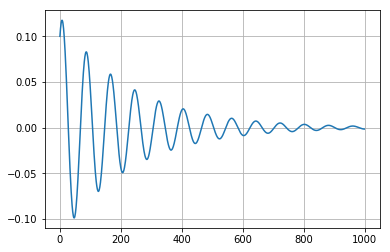

In [8]:
r = 0.035
s = 0.5
m = 0.2
inits = np.array([0.1, 0.1])

def dampedshm_equation(state, t):
    x, y = tf.unstack(state)
    dx = y
    dy = (-r*y - s*x)/m
    return tf.stack([dx, dy])

x, y = hp.generate_tensorflowsession(dampedshm_equation, inits)

hp.plotface(x, grid=1)

[0.1 0.1]
[0.035, 0.5, 0.2]


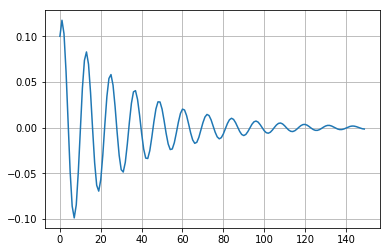

[0.1 0.1]
[0.035, 0.5, 0.2]


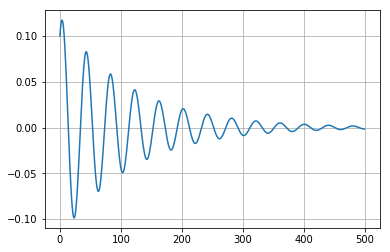

In [13]:
class Model:

    def __init__(
            self,
            initial_conditions=None,
            model_parameters=None,
            final_time=None,
            time_steps=None):
        self.initial_conditions = initial_conditions
        self.model_parameters = model_parameters
        self.final_time = final_time
        self.time_steps = time_steps

    def init_converter(self, arg1: np.array) -> tf.constant:
        """Initial conditions converter.

        Converts the initial_conditions ndarray into a Tensorflow
        constant n-dimensional tensor.

        `tf.constant <https://www.tensorflow.org/api_docs/python/tf/constant>`_

        Parameters
        ----------
        arg1
            Initial conditions for the system of ODEs to be solved.

        Returns
        -------
        tf.constant
            Constant tf.float64 n-d tensor based on initial_conditions
            provided.

        """
        init_state = tf.constant(arg1, dtype=tf.float64)
        return init_state

    def ode_solver(self, arg1: tf.stack, arg2: np.ndarray) -> list:
        """Ordinary Differential Equation (ODE) solver.

        Uses Tensorflow/Numpy odeint to numerically solve the input system
        of ODEs given the provided initial conditions and optional time
        array parameters.

        `odeint <https://www.tensorflow.org/api_docs/python/tf/contrib/integrate/odeint>`_

        Parameters
        ----------
        arg1
            Tensorflow stack representing the equations for the system of ODEs.
        arg2
            Initial conditions for the system of ODEs to be solved.
        initial_time : int
            Initial time value for the time array.
        final_time : int
            Final time value for the time array.
        time_steps : int
            Number of steps between initial and final time in time array.

        Returns
        -------
        list
            y: (n+1)-d tensor. Contains the solved value of y for each desired
            time point in t.
            info_dict: only if full_output=True for odeint, additional info.

        """
        t = np.linspace(0, self.final_time, num=self.time_steps)
        tensor_state, tensor_info = tf.contrib.integrate.odeint(arg1, self.init_converter(arg2), t,
                                                                full_output=True)
        return [tensor_state, tensor_info]

    def tf_session(self, arg1: tf.stack, arg2: np.ndarray) -> np.ndarray:
        """Tensorflow session runner.

        Uses a Tensorflow session run to evaluate the provided system of ODEs.

        `tf.Session.run <https://www.tensorflow.org/api_docs/python/tf/Session#run>`_

        Parameters
        ----------
        arg1
            Tensorflow stack representing the equations for the system of ODEs.
        arg2
            Initial conditions for the system of ODEs to be solved.
        initial_time : int
            Initial time value for the time array.
        final_time : int
            Final time value for the time array.
        time_steps : int
            Number of steps between initial and final time in time array.

        Returns
        -------
        np.ndarray
            Returns the transpose of the (n+1)-d state tensor returned from
            ode_solver after it's been solved in the Tensorflow session.

        """
        sess = tf.Session()
        state, info = sess.run(self.ode_solver(arg1, arg2))
        output = state.T
        return output

    
class DampedSHM(Model):

    def __init__(
            self,
            initial_conditions=[0.1, 0.1],
            model_parameters=[0.035, 0.5, 0.2],
            final_time=50,
            time_steps=150):
        self.initial_conditions = np.array(initial_conditions)
        self.model_parameters = model_parameters
        self.final_time = final_time
        self.time_steps = time_steps

    def equations(self, state, t):
        x, y = tf.unstack(state)
        dx = y
        dy = (-self.model_parameters[0] * y - self.model_parameters[1] * x) / self.model_parameters[2]
        return tf.stack([dx, dy])

    def solve(self):
        self.solution = self.tf_session(self.equations, self.initial_conditions)
        return self.solution


q = DampedSHM()
print(q.initial_conditions)
print(q.model_parameters)
x, y = q.solve()
hp.plotface(x, grid=1)

f = DampedSHM(time_steps=500)
print(f.initial_conditions)
print(f.model_parameters)
g, h = f.solve()
hp.plotface(g, grid=1)

#### Coupled Damped SHM - Beats

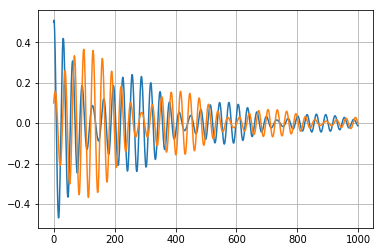

In [10]:
b = 0.007
k1 = 0.27
k2 = 0.027
m = 0.25
inits = [0.5, 0.1, 0.1, 0.1]

def coupledoscillators_equation(state, t):
    x, y, x1, y1 = tf.unstack(state)
    dx = y
    dy = -(k1/m)*x + (k2/m)*x1 - (b/m)*y
    dx1 = y1
    dy1 = (k2/m)*x - (k1/m)*x1 - (b/m)*y1
    return tf.stack([dx, dy, dx1, dy1])

x, y, x1, y1 = hp.generate_tensorflowsession(coupledoscillators_equation, inits, tfinal=200)

plt.plot(x)
plt.plot(x1)
plt.grid()

[0.5 0.1 0.1 0.1]
[0.007, 0.27, 0.027, 0.25]
[0.5 0.1 0.1 0.1]
[0.007, 0.27, 0.027, 0.25]


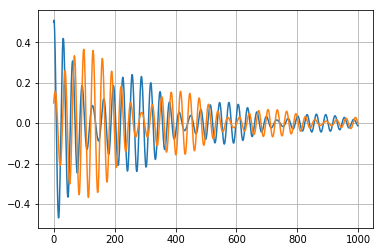

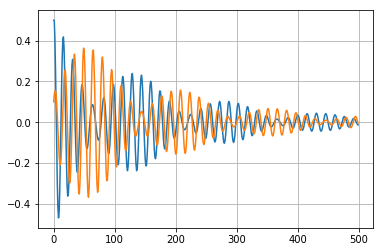

In [15]:
class Model:

    def __init__(
            self,
            initial_conditions=None,
            model_parameters=None,
            final_time=None,
            time_steps=None):
        self.initial_conditions = initial_conditions
        self.model_parameters = model_parameters
        self.final_time = final_time
        self.time_steps = time_steps

    def init_converter(self, arg1: np.array) -> tf.constant:
        """Initial conditions converter.

        Converts the initial_conditions ndarray into a Tensorflow
        constant n-dimensional tensor.

        `tf.constant <https://www.tensorflow.org/api_docs/python/tf/constant>`_

        Parameters
        ----------
        arg1
            Initial conditions for the system of ODEs to be solved.

        Returns
        -------
        tf.constant
            Constant tf.float64 n-d tensor based on initial_conditions
            provided.

        """
        init_state = tf.constant(arg1, dtype=tf.float64)
        return init_state

    def ode_solver(self, arg1: tf.stack, arg2: np.ndarray) -> list:
        """Ordinary Differential Equation (ODE) solver.

        Uses Tensorflow/Numpy odeint to numerically solve the input system
        of ODEs given the provided initial conditions and optional time
        array parameters.

        `odeint <https://www.tensorflow.org/api_docs/python/tf/contrib/integrate/odeint>`_

        Parameters
        ----------
        arg1
            Tensorflow stack representing the equations for the system of ODEs.
        arg2
            Initial conditions for the system of ODEs to be solved.
        initial_time : int
            Initial time value for the time array.
        final_time : int
            Final time value for the time array.
        time_steps : int
            Number of steps between initial and final time in time array.

        Returns
        -------
        list
            y: (n+1)-d tensor. Contains the solved value of y for each desired
            time point in t.
            info_dict: only if full_output=True for odeint, additional info.

        """
        t = np.linspace(0, self.final_time, num=self.time_steps)
        tensor_state, tensor_info = tf.contrib.integrate.odeint(arg1, self.init_converter(arg2), t,
                                                                full_output=True)
        return [tensor_state, tensor_info]

    def tf_session(self, arg1: tf.stack, arg2: np.ndarray) -> np.ndarray:
        """Tensorflow session runner.

        Uses a Tensorflow session run to evaluate the provided system of ODEs.

        `tf.Session.run <https://www.tensorflow.org/api_docs/python/tf/Session#run>`_

        Parameters
        ----------
        arg1
            Tensorflow stack representing the equations for the system of ODEs.
        arg2
            Initial conditions for the system of ODEs to be solved.
        initial_time : int
            Initial time value for the time array.
        final_time : int
            Final time value for the time array.
        time_steps : int
            Number of steps between initial and final time in time array.

        Returns
        -------
        np.ndarray
            Returns the transpose of the (n+1)-d state tensor returned from
            ode_solver after it's been solved in the Tensorflow session.

        """
        sess = tf.Session()
        state, info = sess.run(self.ode_solver(arg1, arg2))
        output = state.T
        return output


class CoupledDampedSHM(Model):

    def __init__(
            self,
            initial_conditions=[0.5, 0.1, 0.1, 0.1],
            model_parameters=[0.007, 0.27, 0.027, 0.25],
            final_time=200,
            time_steps=1000):
        self.initial_conditions = np.array(initial_conditions)
        self.model_parameters = model_parameters
        self.final_time = final_time
        self.time_steps = time_steps

    def equations(self, state, t):
        x, y, x1, y1 = tf.unstack(state)
        dx = y
        dy = -(self.model_parameters[1] / self.model_parameters[3]) * x \
            + (self.model_parameters[2] / self.model_parameters[3]) * x1 \
            - (self.model_parameters[0] / self.model_parameters[3]) * y
        dx1 = y1
        dy1 = (self.model_parameters[2] / self.model_parameters[3]) * x \
            - (self.model_parameters[1] / self.model_parameters[3]) * x1 \
            - (self.model_parameters[0] / self.model_parameters[3]) * y1
        return tf.stack([dx, dy, dx1, dy1])

    def solve(self):
        self.solution = self.tf_session(self.equations, self.initial_conditions)
        return self.solution

q = CoupledDampedSHM()
print(q.initial_conditions)
print(q.model_parameters)
x, y, x1, y1 = q.solve()
plt.figure()
plt.plot(x)
plt.plot(x1)
plt.grid()

f = CoupledDampedSHM(time_steps=500)
print(f.initial_conditions)
print(f.model_parameters)
g, h, g1, h1 = f.solve()
plt.figure()
plt.plot(g)
plt.plot(g1)
plt.grid()

[0.01 0.01]
[-0.05]


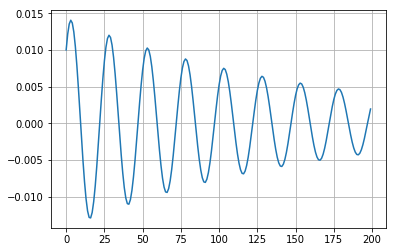

In [8]:
class Vanderpol(hp.Model):

    """

    """

    def __init__(
            self,
            initial_conditions=[0.01, 0.01],
            model_parameters=[-0.05],
            final_time=50,
            time_steps=200):
        self.initial_conditions = np.array(initial_conditions)
        self.model_parameters = model_parameters
        self.final_time = final_time
        self.time_steps = time_steps

    def equations(self, state, t):
        x, y = tf.unstack(state)
        dx = y
        dy = self.model_parameters[0]*y*(1 - x**2) - x
        return tf.stack([dx, dy])

    def solve(self):
        self.solution = self.tf_session(self.equations, self.initial_conditions)
        return self.solution

q = Vanderpol()
print(q.initial_conditions)
print(q.model_parameters)
x, y = q.solve()
hp.plotface(x, grid=1)